In [16]:
from pycocotools.coco import COCO
json_file = '../data/yunnan_512/train/train.json'
coco = COCO(json_file)

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [17]:
anns = coco.anns
num_points = []
for ann_id, ann in anns.items():
    num_points.append(len(ann['segmentation'][0]) // 2)
#     if num_points[-1] > 200:
#         print(ann)

In [18]:
print(sum(num_points))
print(sum(num_points) / len(num_points))

384867
6.440641943905215


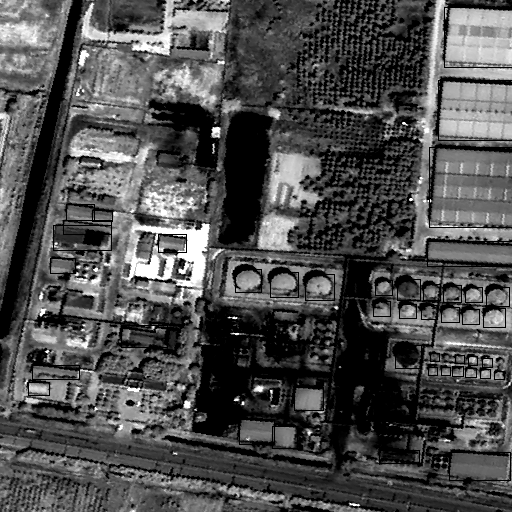

In [9]:
img_ids = [35]
import os
from PIL import Image, ImageDraw
img_dir = '../data/jinan/pan/train/JPEGImages'
for bi, img_id in enumerate(img_ids):
    data_info = coco.loadImgs([img_id])[0]
    
    img_path = os.path.join(img_dir, data_info['file_name'])
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    
    annotations_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
    coco_annotations = coco.loadAnns(annotations_ids)
    for idx, anno in enumerate(coco_annotations):
        if anno['bbox'][2] < 1 or anno['bbox'][3] < 1:
            continue
        x1, y1, w, h = anno['bbox']
        draw.rectangle((x1, y1, x1 + w, y1 + h))
    display(img)
    
    if bi > 10:
        break

### 统计评估结果

| 数据集 | gt | rect | poly | mask | polyrnn |
| - | - | - | - | - | - |
| jinan | 5.3 | 4 | 7.9 | 12.5 | -
| yunnan | 6.4 | 4 | 12.1 | 17.8 | 12.7 


In [49]:
import pickle
input_file = '../venus_last/15/result.pkl'
with open(input_file, 'rb') as f:
    results = pickle.load(f)

In [50]:
import pycocotools.mask as mask_util
from tqdm import tqdm
import cv2
import numpy as np
def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4

    Returns:
        contours, hierarchy
    """
    if cv2.__version__.startswith('4'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif cv2.__version__.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 3 or 4 to call this method')

    return contours, hierarchy

num_points = []
for i in tqdm(range(len(results))):
    result = results[i]
    if len(result[0][0]) == 0:
        continue
    imgs = mask_util.decode(result[1][0])
    h, w, c = imgs.shape
    img_segm = []
    for j in range(c):
        img = imgs[:, :, [j]]
        contours, _ = findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue
        contours = np.concatenate(contours, axis=0)
        contour = cv2.convexHull(contours)
        num_points.append(len(contour))

100%|██████████| 3509/3509 [00:55<00:00, 63.47it/s] 


In [51]:
print(sum(num_points) / len(num_points))

12.69955202195496


### 统计

In [47]:
from pycocotools.coco import COCO
json_file = '../data/yunnan_512/train/train.json'
coco = COCO(json_file)

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


In [48]:
print(len(coco.imgs))
print(len(coco.anns))

10512
59756
